In [1]:
import xarray as xr
import rioxarray
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [3]:
def cdf(data):
    # compute cdf values for a 1D array of data
    data = data[~np.isnan(data)] # remove any NaN values
    x = np.sort(data) #sort data
    y = 1. * np.arange(len(data)) / (len(data) - 1) #calculate CDF values
    return x, y

In [4]:
def mountain_mask(ds, resampling=5):
    '''Given a dataset (ds), create a mountain mask from the MODIS Mountain Snow Classes map using reproject match.
       Use resampling=0 for nearest neighbor (when 1km mountain mask is coarser spatial resolution than target dataset)
       Use resampling=5 for average (when 1km mountain mask is finer spatial resolution than target dataset)
       More options and details here: https://rasterio.readthedocs.io/en/stable/api/rasterio.enums.html#rasterio.enums.Resampling'''
    
    # open the mountain mask file
    mtnsnow_classes = xr.open_rasterio(base_filepath + 'MODIS_mtnsnow_classes/MODIS_mtnsnow_classes.tif').squeeze()
    
    # Clip to North America to match spatial extent of NoahMP models (Longitudes: -169 to -51, Latitudes: 24 to 72)
    min_lon, max_lon = -169, -51
    min_lat, max_lat = 24, 72
    mtnsnow_classes = mtnsnow_classes.rio.clip_box(minx=min_lon, miny=min_lat, maxx=max_lon, maxy=max_lat)
    
    # set values that are 256 (the nodata value) to zero before resampling
    mtnsnow_classes = mtnsnow_classes.where(mtnsnow_classes!=256, 0)
    
    # resample to match target dataset (ds) spatial resolution
    mtnsnow_classes_rpr = mtnsnow_classes.rio.reproject_match(ds, resampling=resampling)
    
    # create the mountain mask by finding all non-zero pixels, these are mountains
    mtn_mask = mtnsnow_classes_rpr.where(mtnsnow_classes_rpr>0).isnull()
    
    return mtn_mask

---

### North America, February Mean SWE

| SWE Dataset | Date Range | Projection | Spatial Resolution |
| --- | --- | --- | ---|
|GlobSnow v3.0 | 2009-2016 | EASE grid (EPSG:3408) | 25 km |
|Noah MP GDAS | 2009-2017 | WGS84 (EPSG:4326) | 5 km |
|Noah MP ECMWF | 2009-2017 | WGS84 (EPSG:4326) | 5 km |

SWE values below 0.1 mm are removed from each dataset (0.1 mm was used rather than 0 to remove zeros that had rounding errors) along with nodata values and replaced with NaNs.

From [GlobSnow v3.0](https://www.globsnow.info/index.php?page=Snow_Water_Equivalent) ([monthly SWE](doi:10.1594/PANGAEA.911944)), mean SWE across all Februarys from 2009-2016 is first computed. This GlobSnow product comes in a 25 km spatial resolution EASE grid ([EPSG:3408](https://epsg.io/3408)) map projection. The February mean SWE map is then reprojected (nearest neighbor) into WGS 84 ([EPSG:4326](https://epsg.io/4326)) to match the projection of the Noah MP datasets. The map is clipped to the same spatial extent as Noah MP (Longitudes: -169 to -51, Latitudes: 24 to 72), then resampled (nearest neighbor) to the spatial resolution of Noah MP (5 km) to before masking out mountain regions.

Mountain regions, identified as all mountain classes in the Seasonal Mountain Snow Classes product ([Wrzesien et al., 2019](https://doi.org/10.1029/2019WR025350)), are masked out of each dataset. The Seasonal Mountain Snow Classes product is first resampled (using averaging) from its original 1 km spatial resolution to 5 km prior to masking.

Finally, a cumulative distribution curve is computed for each SWE map.

In [5]:
base_filepath = 'C:/Users/steve/OneDrive/Documents/School Stuff/UW/Mountain Hydrology Research Group/Snow Sensor Usability Paper - Passive Microwave/Data/'

#### North America, NoahMP GDAS

In [6]:
# read in NoahMP GDAS February mean SWE geotiff
swe_noahmp_gdas_febmean_mm = xr.open_rasterio(base_filepath + 'NoahMP/swe_noahmp_gdas_febmean_mm.tif').squeeze()

# replace nodata values (-1, or anything negative) and zeros with NaNs
swe_noahmp_gdas_febmean_mm = swe_noahmp_gdas_febmean_mm.where(swe_noahmp_gdas_febmean_mm > .1)

# apply the mountain mask
swe_noahmp_gdas_febmean_mm = swe_noahmp_gdas_febmean_mm.where(mountain_mask(swe_noahmp_gdas_febmean_mm))

# compute NoahMP GDAS CDF
na_gdas_cdf_x, na_gdas_cdf_y = cdf(swe_noahmp_gdas_febmean_mm.values.ravel())

# convert to a pandas dataframe
gdas_cdf_df = pd.DataFrame(data={'cdf_x': na_gdas_cdf_x, 'cdf_y': na_gdas_cdf_y})

# export CDF values to a csv file
gdas_cdf_df.to_csv('swe_noahmp_gdas_febmean_mm_CDF.csv')

C:\Users\steve\AppData\Local\Temp\ipykernel_16848\2448571876.py:2: DeprecationWarning: open_rasterio is Deprecated in favor of rioxarray. For information about transitioning, see: https://corteva.github.io/rioxarray/stable/getting_started/getting_started.html
  swe_noahmp_gdas_febmean_mm = xr.open_rasterio(base_filepath + 'NoahMP/swe_noahmp_gdas_febmean_mm.tif').squeeze()
C:\Users\steve\AppData\Local\Temp\ipykernel_16848\3812810329.py:8: DeprecationWarning: open_rasterio is Deprecated in favor of rioxarray. For information about transitioning, see: https://corteva.github.io/rioxarray/stable/getting_started/getting_started.html
  mtnsnow_classes = xr.open_rasterio(base_filepath + 'MODIS_mtnsnow_classes/MODIS_mtnsnow_classes.tif').squeeze()


#### North America, NoahMP ECMWF

In [7]:
# read in NoahMP ECMWF February mean SWE geotiff
swe_noahmp_ecmwf_febmean_mm = xr.open_rasterio(base_filepath + 'NoahMP/swe_noahmp_ecmwf_febmean_mm.tif').squeeze()

# replace nodata values (-1, or anything negative) and zeros with NaNs
swe_noahmp_ecmwf_febmean_mm = swe_noahmp_ecmwf_febmean_mm.where(swe_noahmp_ecmwf_febmean_mm > .1)

# apply the mountain mask
swe_noahmp_ecmwf_febmean_mm = swe_noahmp_ecmwf_febmean_mm.where(mountain_mask(swe_noahmp_ecmwf_febmean_mm))

# compute NoahMP ECMWF CDF
na_ecmwf_cdf_x, na_ecmwf_cdf_y = cdf(swe_noahmp_ecmwf_febmean_mm.values.ravel())

# convert to a pandas dataframe
ecmwf_cdf_df = pd.DataFrame(data={'cdf_x': na_ecmwf_cdf_x, 'cdf_y': na_ecmwf_cdf_y})

# export CDF values to a csv file
ecmwf_cdf_df.to_csv('swe_noahmp_ecmwf_febmean_mm_CDF.csv')

C:\Users\steve\AppData\Local\Temp\ipykernel_16848\1569281722.py:2: DeprecationWarning: open_rasterio is Deprecated in favor of rioxarray. For information about transitioning, see: https://corteva.github.io/rioxarray/stable/getting_started/getting_started.html
  swe_noahmp_ecmwf_febmean_mm = xr.open_rasterio(base_filepath + 'NoahMP/swe_noahmp_ecmwf_febmean_mm.tif').squeeze()
C:\Users\steve\AppData\Local\Temp\ipykernel_16848\3812810329.py:8: DeprecationWarning: open_rasterio is Deprecated in favor of rioxarray. For information about transitioning, see: https://corteva.github.io/rioxarray/stable/getting_started/getting_started.html
  mtnsnow_classes = xr.open_rasterio(base_filepath + 'MODIS_mtnsnow_classes/MODIS_mtnsnow_classes.tif').squeeze()


#### North America, GlobSnow

In [8]:
# find GlobSnow SWE NetCDF files for Feb
filepaths = glob.glob(base_filepath + 'GlobSnow/GlobSnow-2009-2016/????02*.nc') # search for filepaths with YYYY02, for February of all years

# open each February GlobSnow SWE map and reproject to WGS84
ds_list = []
for filepath in filepaths:
    ds = xr.open_dataset(filepath)
    ds_swe = ds.swe.rio.set_crs("EPSG:3408").rio.reproject("EPSG:4326") # set crs to EASE grid, then reproject (nearest neighbor) to WGS84
    ds_list.append(ds_swe)
# concat together    
da = xr.concat(ds_list, dim='year')
# take the mean across all years and write CRS
swe_globsnow_mean_mm = da.mean(axis=0).rio.write_crs("EPSG:4326")

# Clip to North America to match spatial extent of NoahMP models (Longitudes: -169 to -51, Latitudes: 24 to 72)
min_lon, max_lon = -169, -51
min_lat, max_lat = 24, 72
swe_globsnow_febmean_mm = swe_globsnow_mean_mm.rio.clip_box(minx=min_lon, miny=min_lat, maxx=max_lon, maxy=max_lat)

# replace values <= 0 with Nan
swe_globsnow_febmean_mm = swe_globsnow_febmean_mm.where(swe_globsnow_febmean_mm > .1)

# reproject to NoahMP spatial resolution
swe_globsnow_febmean_mm = swe_globsnow_febmean_mm.rio.reproject_match(swe_noahmp_gdas_febmean_mm, resampling=0) # nearest neighbor

# apply the mountain mask
swe_globsnow_febmean_mm = swe_globsnow_febmean_mm.where(mountain_mask(swe_globsnow_febmean_mm).values)

# compute GlobSnow CDF
na_globsnow_cdf_x, na_globsnow_cdf_y = cdf(swe_globsnow_febmean_mm.values.ravel())

# convert to a pandas dataframe
globsnow_cdf_df = pd.DataFrame(data={'cdf_x': na_globsnow_cdf_x, 'cdf_y': na_globsnow_cdf_y})

# export CDF values to a csv file
globsnow_cdf_df.to_csv('swe_globsnow_febmean_mm_CDF.csv')

C:\Users\steve\AppData\Local\Temp\ipykernel_16848\3812810329.py:8: DeprecationWarning: open_rasterio is Deprecated in favor of rioxarray. For information about transitioning, see: https://corteva.github.io/rioxarray/stable/getting_started/getting_started.html
  mtnsnow_classes = xr.open_rasterio(base_filepath + 'MODIS_mtnsnow_classes/MODIS_mtnsnow_classes.tif').squeeze()


---

### Quebec, February Mean SWE

Geotif outputs from the [Snow Sensor Usability Maps Google Earth Engine script](https://code.earthengine.google.com/?scriptPath=users%2Fspestana%2Fssum%3Amain) ran over Quebec, Canada for 2002 to 2018. The SWE layers for several output files are plotted below.

In [9]:
base_filepath = 'C:/Users/steve/OneDrive/Documents/School Stuff/UW/Mountain Hydrology Research Group/Snow Sensor Usability Paper - Passive Microwave/sensitivity_test_results/ssum_output/'

### Noah MP GDAS
band 0 = MODIS LST; band 1 = Hansen et al., TCC; band 2 = NoahMP GDAS SWE; band 3 = classes

In [10]:
ds = xr.open_rasterio(base_filepath + 'quebec_ssum_noahmp_gdas_150_tcc_20-30.tif')
gdas = ds.isel(band=2)

# compute NoahMP GDAS CDF
qc_gdas_cdf_x, qc_gdas_cdf_y = cdf(gdas.values.ravel())
# convert to a pandas dataframe
gdas_cdf_df = pd.DataFrame(data={'cdf_x': qc_gdas_cdf_x, 'cdf_y': qc_gdas_cdf_y})
# export CDF values to a csv file
gdas_cdf_df.to_csv('quebec_swe_noahmp_gdas_febmean_mm_CDF.csv')

C:\Users\steve\AppData\Local\Temp\ipykernel_16848\716859193.py:1: DeprecationWarning: open_rasterio is Deprecated in favor of rioxarray. For information about transitioning, see: https://corteva.github.io/rioxarray/stable/getting_started/getting_started.html
  ds = xr.open_rasterio(base_filepath + 'quebec_ssum_noahmp_gdas_150_tcc_20-30.tif')


### Noah MP ECMWF
band 0 = MODIS LST; band 1 = Hansen et al., TCC; band 2 = NoahMP ECMWF SWE; band 3 = classes

In [11]:
ds = xr.open_rasterio(base_filepath + 'quebec_ssum_noahmp_ecmwf_150_tcc_20-30.tif')
ecmwf = ds.isel(band=2)

# compute NoahMP ECMWF CDF
qc_ecmwf_cdf_x, qc_ecmwf_cdf_y = cdf(ecmwf.values.ravel())
# convert to a pandas dataframe
ecmwf_cdf_df = pd.DataFrame(data={'cdf_x': qc_ecmwf_cdf_x, 'cdf_y': qc_ecmwf_cdf_y})
# export CDF values to a csv file
ecmwf_cdf_df.to_csv('quebec_swe_noahmp_ecmwf_febmean_mm_CDF.csv')

C:\Users\steve\AppData\Local\Temp\ipykernel_16848\1942742662.py:1: DeprecationWarning: open_rasterio is Deprecated in favor of rioxarray. For information about transitioning, see: https://corteva.github.io/rioxarray/stable/getting_started/getting_started.html
  ds = xr.open_rasterio(base_filepath + 'quebec_ssum_noahmp_ecmwf_150_tcc_20-30.tif')


### GlobSnow
band 0 = MODIS LST; band 1 = MODIS LAI; band 2 = GlobSnow SWE; band 3 = classes

In [12]:
ds = xr.open_rasterio(base_filepath + 'quebec_ssum_globsnow_150_lai_18-38.tif')
globsnow = ds.isel(band=2)

# compute GlobSnow CDF
qc_globsnow_cdf_x, qc_globsnow_cdf_y = cdf(globsnow.values.ravel())
# convert to a pandas dataframe
globsnow_cdf_df = pd.DataFrame(data={'cdf_x': qc_globsnow_cdf_x, 'cdf_y': qc_globsnow_cdf_y})
# export CDF values to a csv file
globsnow_cdf_df.to_csv('quebec_swe_globsnow_febmean_mm_CDF.csv')

C:\Users\steve\AppData\Local\Temp\ipykernel_16848\4222652848.py:1: DeprecationWarning: open_rasterio is Deprecated in favor of rioxarray. For information about transitioning, see: https://corteva.github.io/rioxarray/stable/getting_started/getting_started.html
  ds = xr.open_rasterio(base_filepath + 'quebec_ssum_globsnow_150_lai_18-38.tif')


---

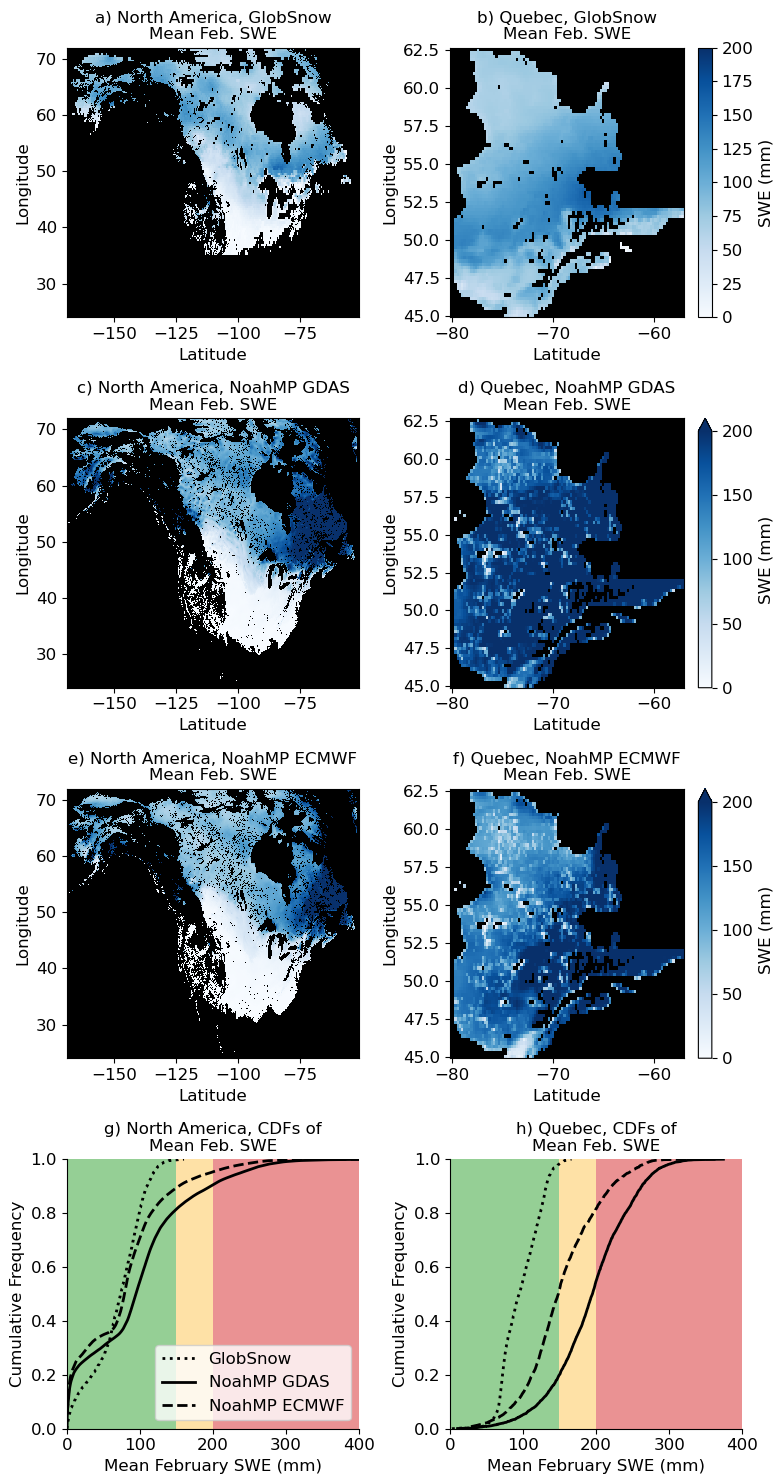

In [14]:
fig, ax = plt.subplots(nrows=4,ncols=2,figsize=(8,15),tight_layout=True,gridspec_kw={'width_ratios': [1, 1]})
[ax_na_globsnow, ax_qc_globsnow, ax_na_gdas, ax_qc_gdas, ax_na_ecmwf, ax_qc_ecmwf, ax_na_cdfs, ax_qc_cdfs] = ax.ravel()

### Map plots ###
# North America GlobSnow map
swe_globsnow_febmean_mm.plot(ax=ax_na_globsnow, vmin=0, vmax=200, cmap='Blues', add_colorbar=False)# cbar_kwargs={'label': 'SWE (mm)'})
# North America NoahMP GDAS map
swe_noahmp_gdas_febmean_mm.plot(ax=ax_na_gdas, vmin=0, vmax=200, cmap='Blues', add_colorbar=False)#, cbar_kwargs={'label': 'SWE (mm)'})
# North America NoahMP ECMWF map
swe_noahmp_ecmwf_febmean_mm.plot(ax=ax_na_ecmwf, vmin=0, vmax=200, cmap='Blues', add_colorbar=False)# cbar_kwargs={'label': 'SWE (mm)'})
# Quebec GlobSnow map
globsnow.plot(ax=ax_qc_globsnow, vmin=0, vmax=200, cmap='Blues', cbar_kwargs={'label': 'SWE (mm)'})
# Quebec NoahMP GDAS map
gdas.plot(ax=ax_qc_gdas, vmin=0, vmax=200, cmap='Blues', cbar_kwargs={'label': 'SWE (mm)'})
# Quebec NoahMP ECMWF map
ecmwf.plot(ax=ax_qc_ecmwf, vmin=0, vmax=200, cmap='Blues', cbar_kwargs={'label': 'SWE (mm)'})
# format map plots
ax_na_globsnow.set_title('a) North America, GlobSnow\nMean Feb. SWE')
ax_na_gdas.set_title('c) North America, NoahMP GDAS\nMean Feb. SWE')
ax_na_ecmwf.set_title('e) North America, NoahMP ECMWF\nMean Feb. SWE')
ax_qc_globsnow.set_title('b) Quebec, GlobSnow\nMean Feb. SWE')
ax_qc_gdas.set_title('d) Quebec, NoahMP GDAS\nMean Feb. SWE')
ax_qc_ecmwf.set_title('f) Quebec, NoahMP ECMWF\nMean Feb. SWE')
for this_ax in ax.ravel()[:6]:
    this_ax.set_ylabel('Longitude')
    this_ax.set_xlabel('Latitude')
    this_ax.set_facecolor("black")


### CDF plots ###
# North America GlobSnow CDF
ax_na_cdfs.plot(na_globsnow_cdf_x, na_globsnow_cdf_y, ':', c='k', lw=2, label='GlobSnow')
# North America NoahMP GDAS CDF
ax_na_cdfs.plot(na_gdas_cdf_x, na_gdas_cdf_y, '-', c='k', lw=2,  label='NoahMP GDAS')
# North America  NoahMP ECMWF CDF
ax_na_cdfs.plot(na_ecmwf_cdf_x, na_ecmwf_cdf_y, '--', c='k', lw=2,  label='NoahMP ECMWF')
# add vertical lines or bands for max SWE thresholds
#ax_na_cdfs.axvline(150, c='grey', lw=1, zorder=-99)
#ax_na_cdfs.axvline(200, c='grey', lw=1, zorder=-99)
ax_na_cdfs.fill_between([0, 150], y1=1, y2=0, facecolor='tab:green', alpha=0.5)
ax_na_cdfs.fill_between([150,200], y1=1, y2=0, facecolor='#fec44f', alpha=0.5)
ax_na_cdfs.fill_between([200, 400], y1=1, y2=0, facecolor='tab:red', alpha=0.5)
# format CDF plot
ax_na_cdfs.set_xlim((0,400))
ax_na_cdfs.set_ylim((0,1))
ax_na_cdfs.set_title('g) North America, CDFs of\nMean Feb. SWE')
ax_na_cdfs.set_ylabel('Cumulative Frequency')
ax_na_cdfs.set_xlabel('Mean February SWE (mm)')
ax_na_cdfs.legend(loc='lower right');
ax_na_cdfs.spines['top'].set_visible(False)
ax_na_cdfs.spines['right'].set_visible(False)
#ax2.spines['top'].set_visible(False)
#ax2.spines['right'].set_visible(False)

# Quebec GlobSnow CDF
ax_qc_cdfs.plot(qc_globsnow_cdf_x, qc_globsnow_cdf_y, ':', c='k', lw=2, label='GlobSnow')
# Quebec NoahMP GDAS CDF
ax_qc_cdfs.plot(qc_gdas_cdf_x, qc_gdas_cdf_y, '-', c='k', lw=2,  label='NoahMP GDAS')
# Quebec  NoahMP ECMWF CDF
ax_qc_cdfs.plot(qc_ecmwf_cdf_x, qc_ecmwf_cdf_y, '--', c='k', lw=2,  label='NoahMP ECMWF')
# add vertical lines or bands for max SWE thresholds
#ax_qc_cdfs.axvline(150, c='grey', lw=1, zorder=-99)
#ax_qc_cdfs.axvline(200, c='grey', lw=1, zorder=-99)
ax_qc_cdfs.fill_between([0, 150], y1=1, y2=0, facecolor='tab:green', alpha=0.5)
ax_qc_cdfs.fill_between([150,200], y1=1, y2=0, facecolor='#fec44f', alpha=0.5)
ax_qc_cdfs.fill_between([200, 400], y1=1, y2=0, facecolor='tab:red', alpha=0.5)
# format CDF plot
ax_qc_cdfs.set_xlim((0,400))
ax_qc_cdfs.set_ylim((0,1))
ax_qc_cdfs.set_title('h) Quebec, CDFs of\nMean Feb. SWE')
ax_qc_cdfs.set_ylabel('Cumulative Frequency')
ax_qc_cdfs.set_xlabel('Mean February SWE (mm)')
#ax_qc_cdfs.legend(loc='lower right');
ax_qc_cdfs.spines['top'].set_visible(False)
ax_qc_cdfs.spines['right'].set_visible(False)
#ax2.spines['top'].set_visible(False)
#ax2.spines['right'].set_visible(False)

# save figure
plt.savefig('figures/swe-mountainsmasked.jpg')